In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import pandas_datareader.data as web
import os
import requests
import json
import time
from datetime import datetime

# print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
def btc():
    url = "https://www.bitstamp.net/api/v2/ohlc/btcusd/"
    timeframe = 86400
    start_date = 1312174800
    end_date = int(time.time())

    # set the maximum number of data points to return per request
    limit = 1000

    data_list = []
    while start_date <= end_date:

        request_end_date = min(start_date + limit*timeframe, end_date)
        response = requests.get(url + "?step=" + str(timeframe) + "&start=" + str(start_date) + "&end=" + str(request_end_date) + "&limit=" + str(limit))
        data = json.loads(response.text)
        data_list += data['data']['ohlc']
        start_date += limit*timeframe

    df = pd.DataFrame(data_list)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)

    df.set_index('timestamp',drop=True, inplace = True)
    df.columns = [e.capitalize() for e in df.columns]
    df.sort_index(ascending = True, inplace= True)
    df.drop_duplicates(inplace = True)

    return df


In [3]:
df = btc().copy()

**Bull_Market_Support_Bands**

In [54]:
# Calculating the indicator
indicator = 'Bull_Market_Support_Bands'
df['20w_sma'] = df['Close'].rolling(140).mean()
df['21w_ema'] = df['Close'].ewm(span=147, adjust=False).mean()
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Close,Volume,20w_sma,21w_ema
timestamp,,,,
2023-03-24,27493.0,2789.449515,20247.942857,22011.875764
2023-03-25,27499.0,963.838407,20292.214286,22086.026092
2023-03-26,28004.0,1100.203311,20342.907143,22165.998712
2023-03-27,27142.0,2258.963936,20389.707143,22233.241973
2023-03-28,26905.0,1044.848543,20449.385714,22296.373838


In [55]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Close']/df['Close'].shift(1))
df.tail(3)

#defining minimum of both
df['min_bm_sb'] = df[['20w_sma','21w_ema']].min(axis=1)

# long vs short
df['signal'] = np.where((df['Close'] > df['min_bm_sb']),1,0)
df['signal'] = np.where( (df['Close'] < df['min_bm_sb']),-1,df['signal'])

# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

,Close,Volume,20w_sma,21w_ema,bnh_returns
timestamp,,,,,
2023-03-26,28004.0,1100.203311,20342.907143,22165.998712,0.018198
2023-03-27,27142.0,2258.963936,20389.707143,22233.241973,-0.031265
2023-03-28,26905.0,1044.848543,20449.385714,22296.373838,-0.008770


Buy and hold returns: 7.811304632688415
Strategy returns: 11.423599479664226


<AxesSubplot:xlabel='timestamp'>

Start date,2011-08-18
End date,2023-03-28
Total months,201
,Backtest
Annual return,47.1%
Cumulative returns,64332.3%
Annual volatility,75.2%
Sharpe ratio,0.91
Calmar ratio,0.54
Stability,0.94
Max drawdown,-87.0%


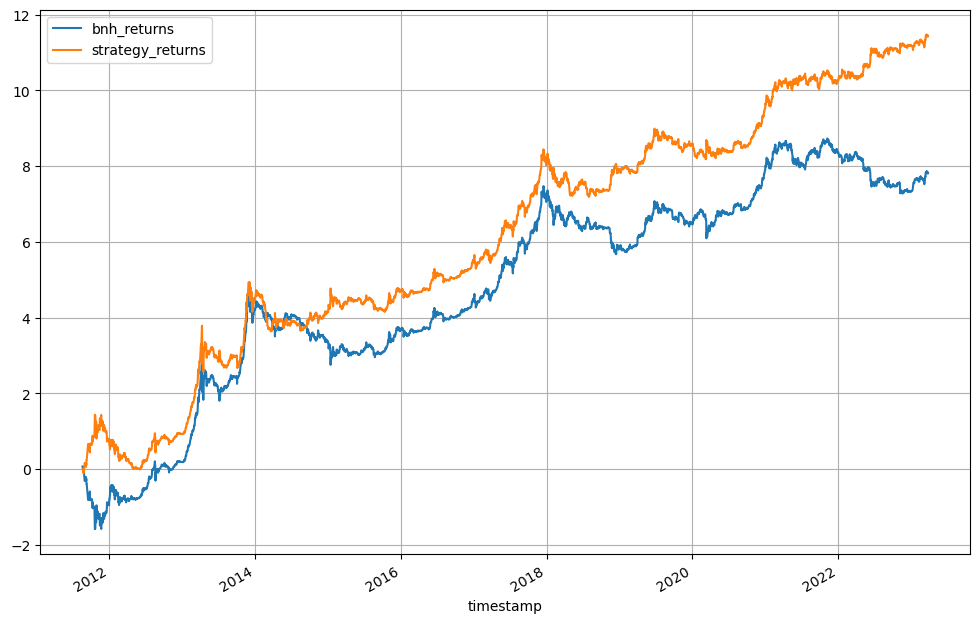

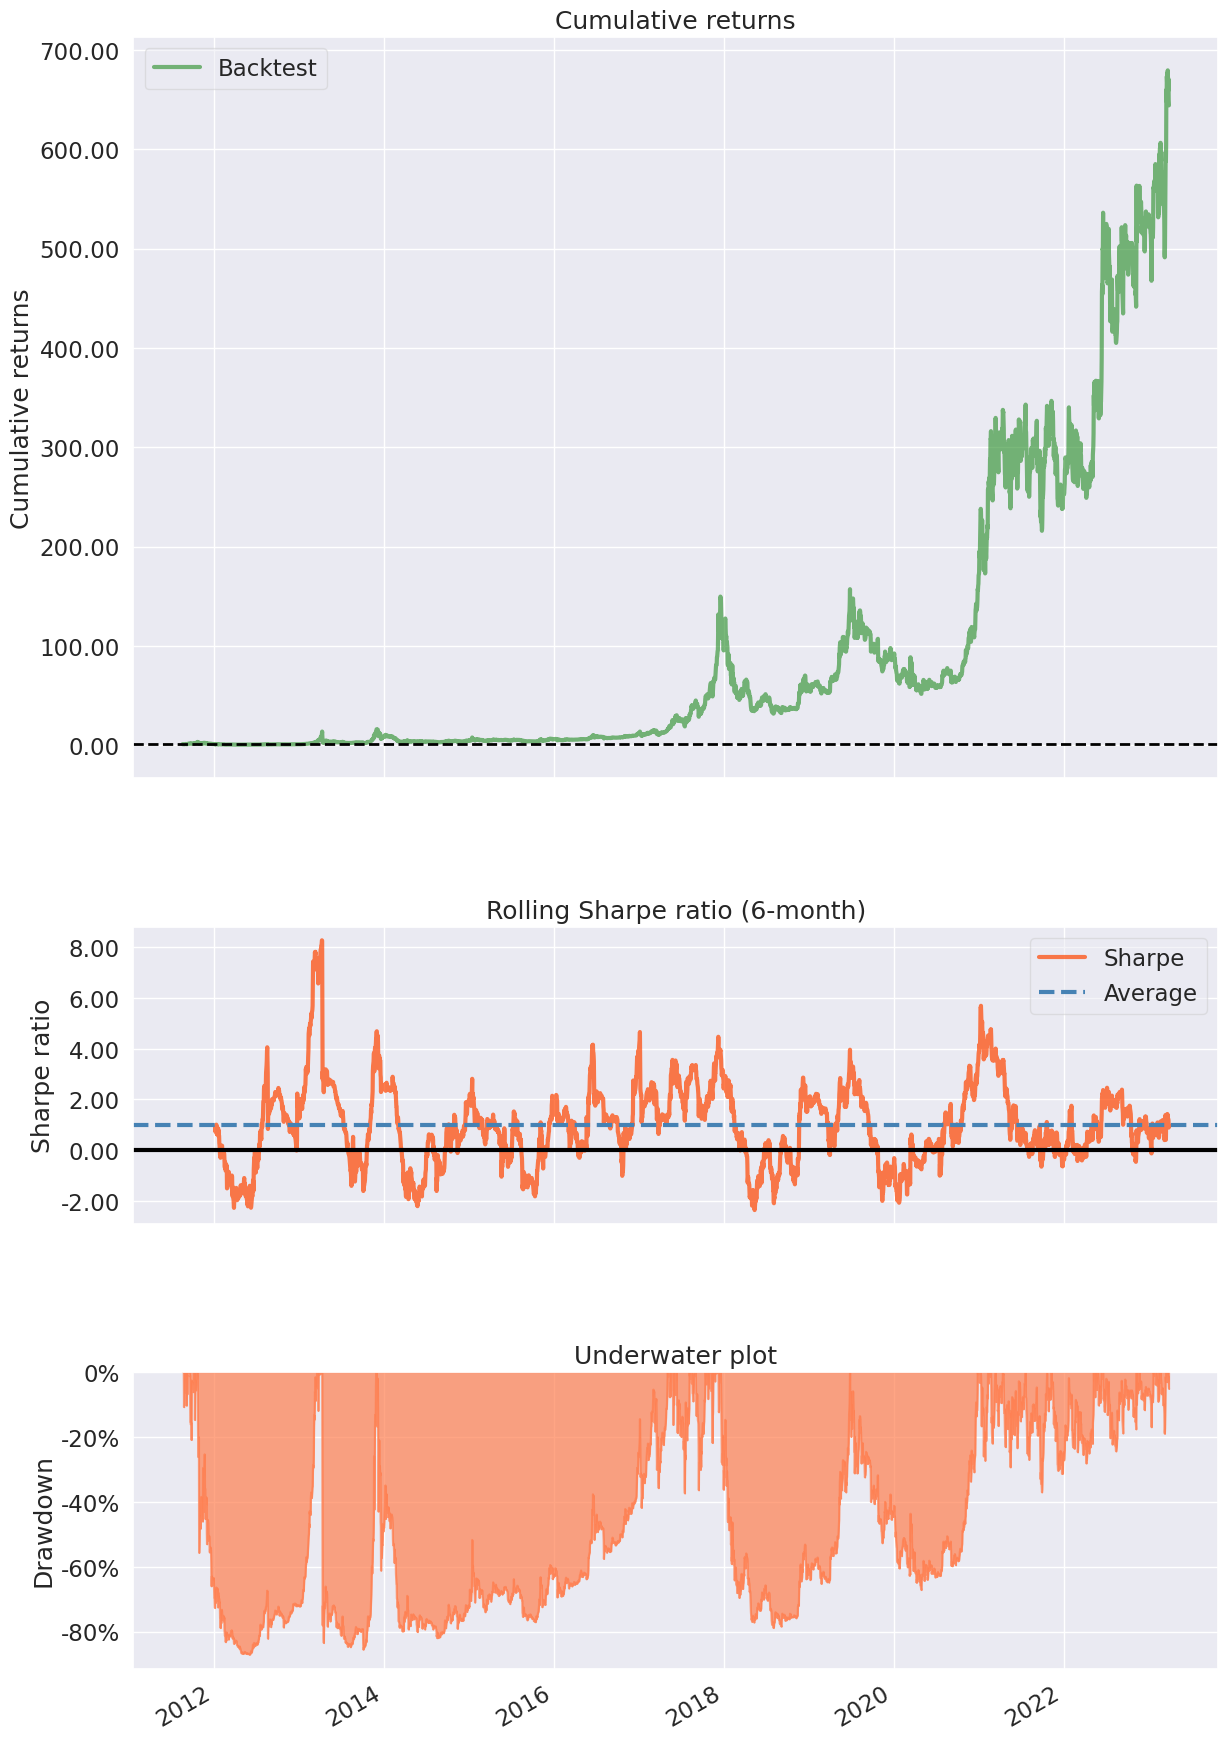

In [56]:
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))
plt.savefig(f'plots/{indicator}.png')

pf.create_simple_tear_sheet(df['strategy_returns'].diff())


**EHMA**

In [18]:
df = btc().copy()

In [25]:
for e in range (10,220):
    period = e
    yukdus = True
    sqrt_period = np.sqrt(period)

    def borserman_ema(x, y):
        alpha = 2 / (y + 1)
        sum = np.array([alpha * x[0]])
        for i in range(1, len(x)):
            value = alpha * x[i] + (1 - alpha) * sum[i-1]
            sum = np.append(sum, value)
        return sum

    close_ema1 = borserman_ema(df['Close'], int(period / 2))
    close_ema2 = borserman_ema(df['Close'], period)
    ehma = borserman_ema(2 * close_ema1 - close_ema2, sqrt_period)

    df['ehma'] =ehma

    df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
    df['bnh_returns'] = np.log(df['Close']/df['Close'].shift(1))


    df['signal'] = np.where((df['ehma'] > df['ehma'].shift(1)),1,0)
    df['signal'] = np.where( (df['ehma'] < df['ehma'].shift(1)),-1,df['signal'])

    # creating long and short positions 
    df['position'] = df['signal'].replace(to_replace=0, method='ffill')

    # shifting by 1, to account of close price return calculations
    df['position'] = df['position'].shift(1)

    # calculating stretegy returns
    df['strategy_returns'] = df['bnh_returns'] * (df['position'])

    print(period)
    print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
    print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

    # plotting strategy historical performance over time
    #df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
    #df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

10
Buy and hold returns: 7.810449407395989
Strategy returns: 9.44040570293868
11
Buy and hold returns: 7.810449407395989
Strategy returns: 10.008066073764965
12
Buy and hold returns: 7.810449407395989
Strategy returns: 9.97438523170646
13
Buy and hold returns: 7.810449407395989
Strategy returns: 9.793474967558062
14
Buy and hold returns: 7.810449407395989
Strategy returns: 9.078204026402009
15
Buy and hold returns: 7.810449407395989
Strategy returns: 8.739428806766426
16
Buy and hold returns: 7.810449407395989
Strategy returns: 8.744637078848555
17
Buy and hold returns: 7.810449407395989
Strategy returns: 9.04685475325633
18
Buy and hold returns: 7.810449407395989
Strategy returns: 8.92581622228009
19
Buy and hold returns: 7.810449407395989
Strategy returns: 8.836294209061933
20
Buy and hold returns: 7.810449407395989
Strategy returns: 9.391828809639517
21
Buy and hold returns: 7.810449407395989
Strategy returns: 9.756176178924704
22
Buy and hold returns: 7.810449407395989
Strategy ret

120
Buy and hold returns: 7.810449407395989
Strategy returns: 11.318892307683981


<AxesSubplot:xlabel='timestamp'>

Start date,2011-08-18
End date,2023-03-28
Total months,201
,Backtest
Annual return,45.9%
Cumulative returns,56437.7%
Annual volatility,75.2%
Sharpe ratio,0.90
Calmar ratio,0.55
Stability,0.93
Max drawdown,-83.4%


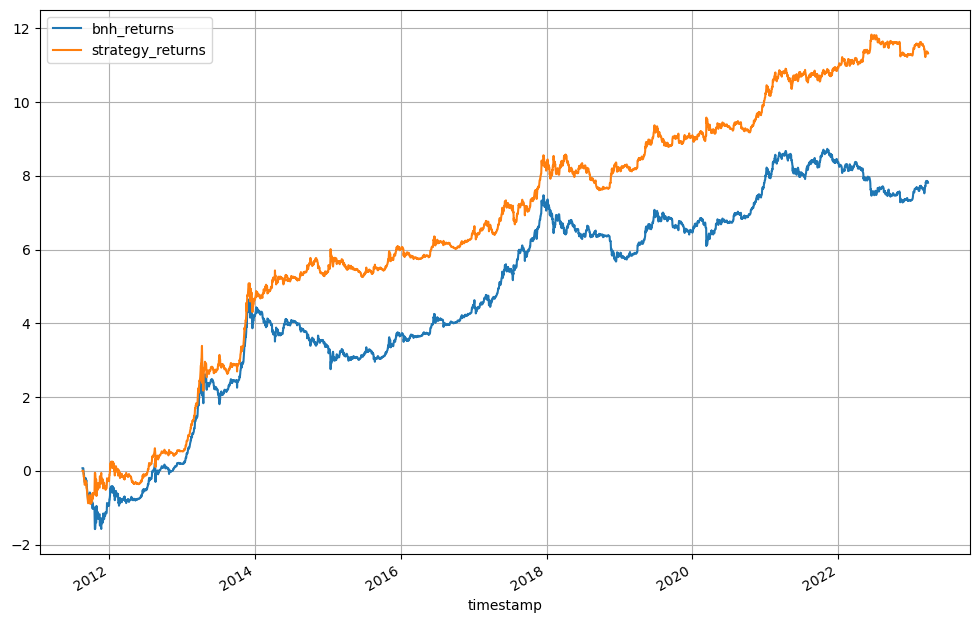

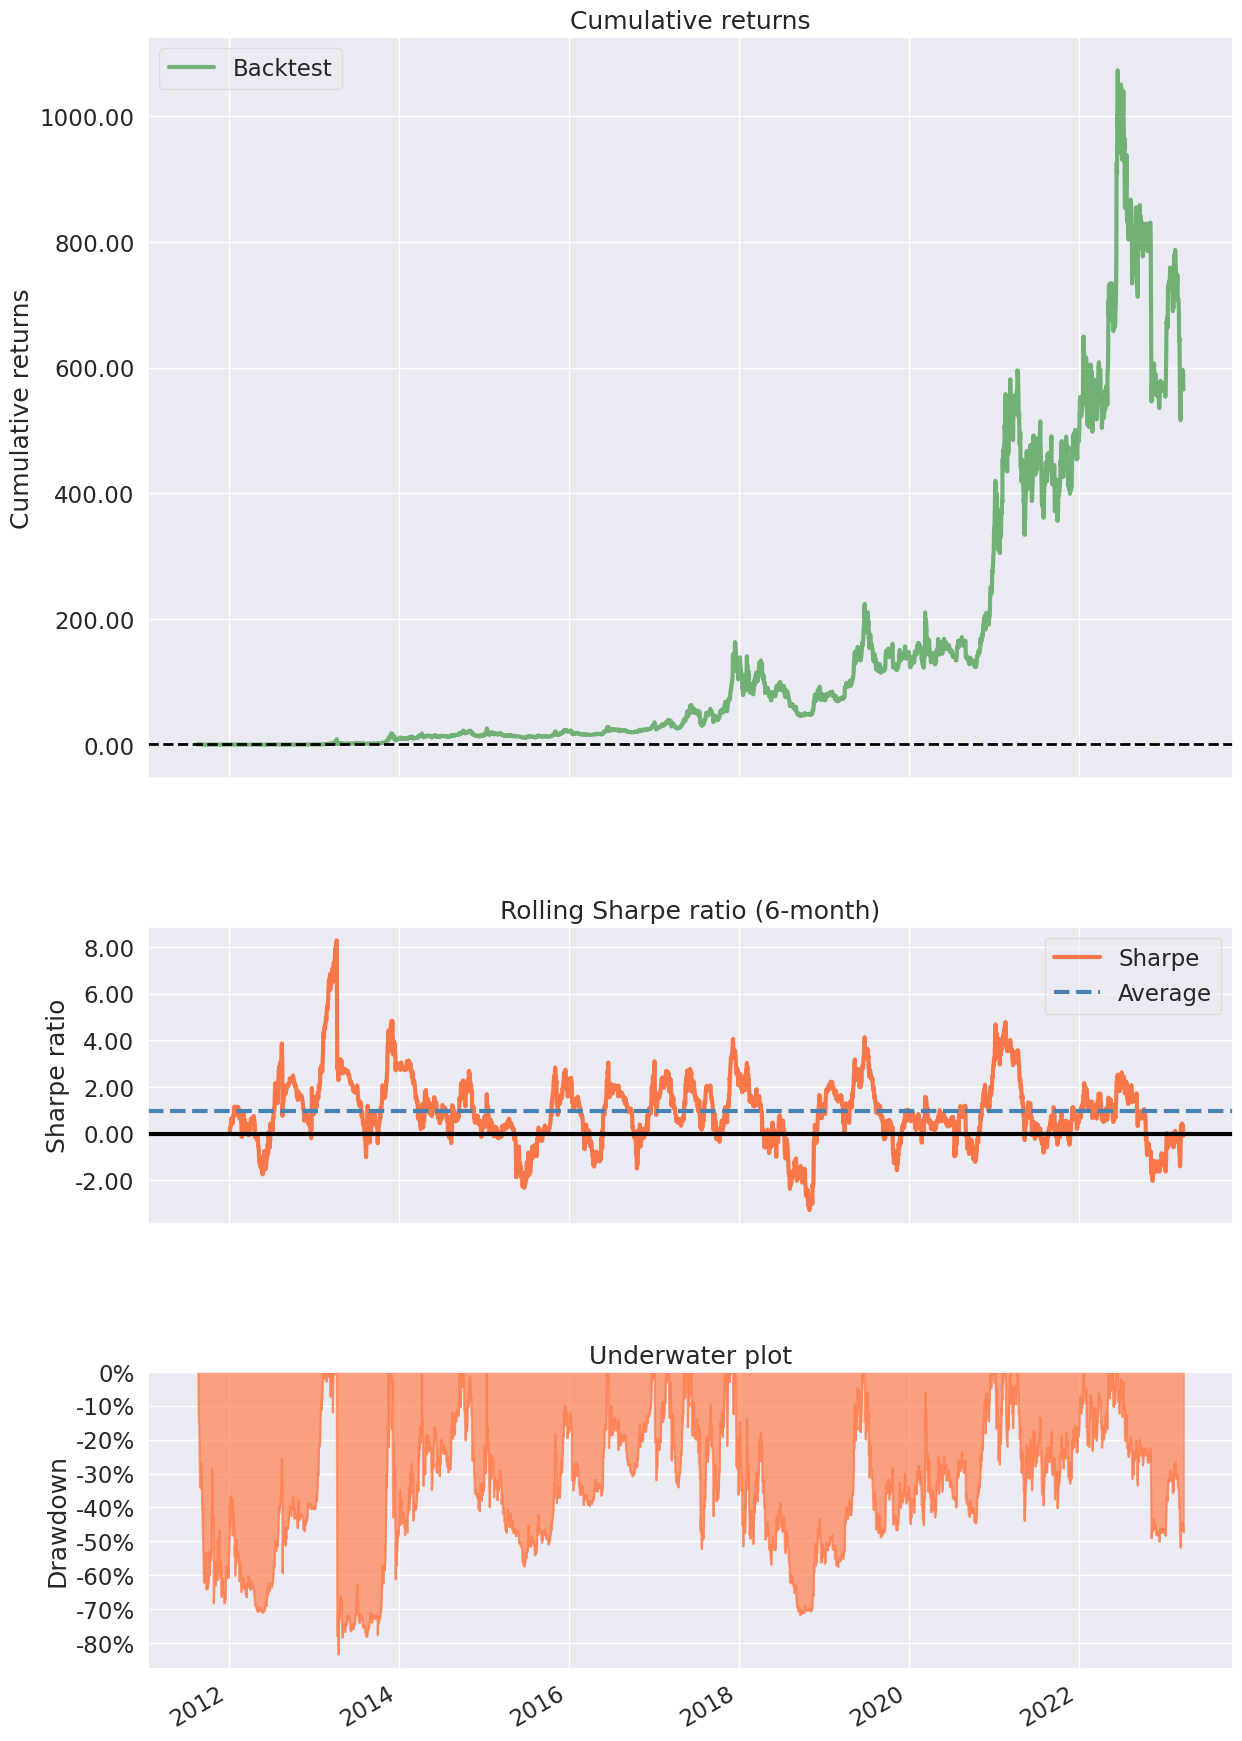

In [26]:
period = 120 #backtested
yukdus = True
sqrt_period = np.sqrt(period)

def borserman_ema(x, y):
    alpha = 2 / (y + 1)
    sum = np.array([alpha * x[0]])
    for i in range(1, len(x)):
        value = alpha * x[i] + (1 - alpha) * sum[i-1]
        sum = np.append(sum, value)
    return sum

close_ema1 = borserman_ema(df['Close'], int(period / 2))
close_ema2 = borserman_ema(df['Close'], period)
ehma = borserman_ema(2 * close_ema1 - close_ema2, sqrt_period)

df['ehma'] =ehma

df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df['bnh_returns'] = np.log(df['Close']/df['Close'].shift(1))


df['signal'] = np.where((df['ehma'] > df['ehma'].shift(1)),1,0)
df['signal'] = np.where( (df['ehma'] < df['ehma'].shift(1)),-1,df['signal'])

# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

print(period)
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))
plt.savefig('plots/ehma.png')


pf.create_simple_tear_sheet(df['strategy_returns'].diff())


Start date,2011-08-18
End date,2023-03-24
Total months,201
,Backtest
Annual return,30.3%
Cumulative returns,8304.4%
Annual volatility,75.3%
Sharpe ratio,0.75
Calmar ratio,0.32
Stability,0.92
Max drawdown,-93.5%


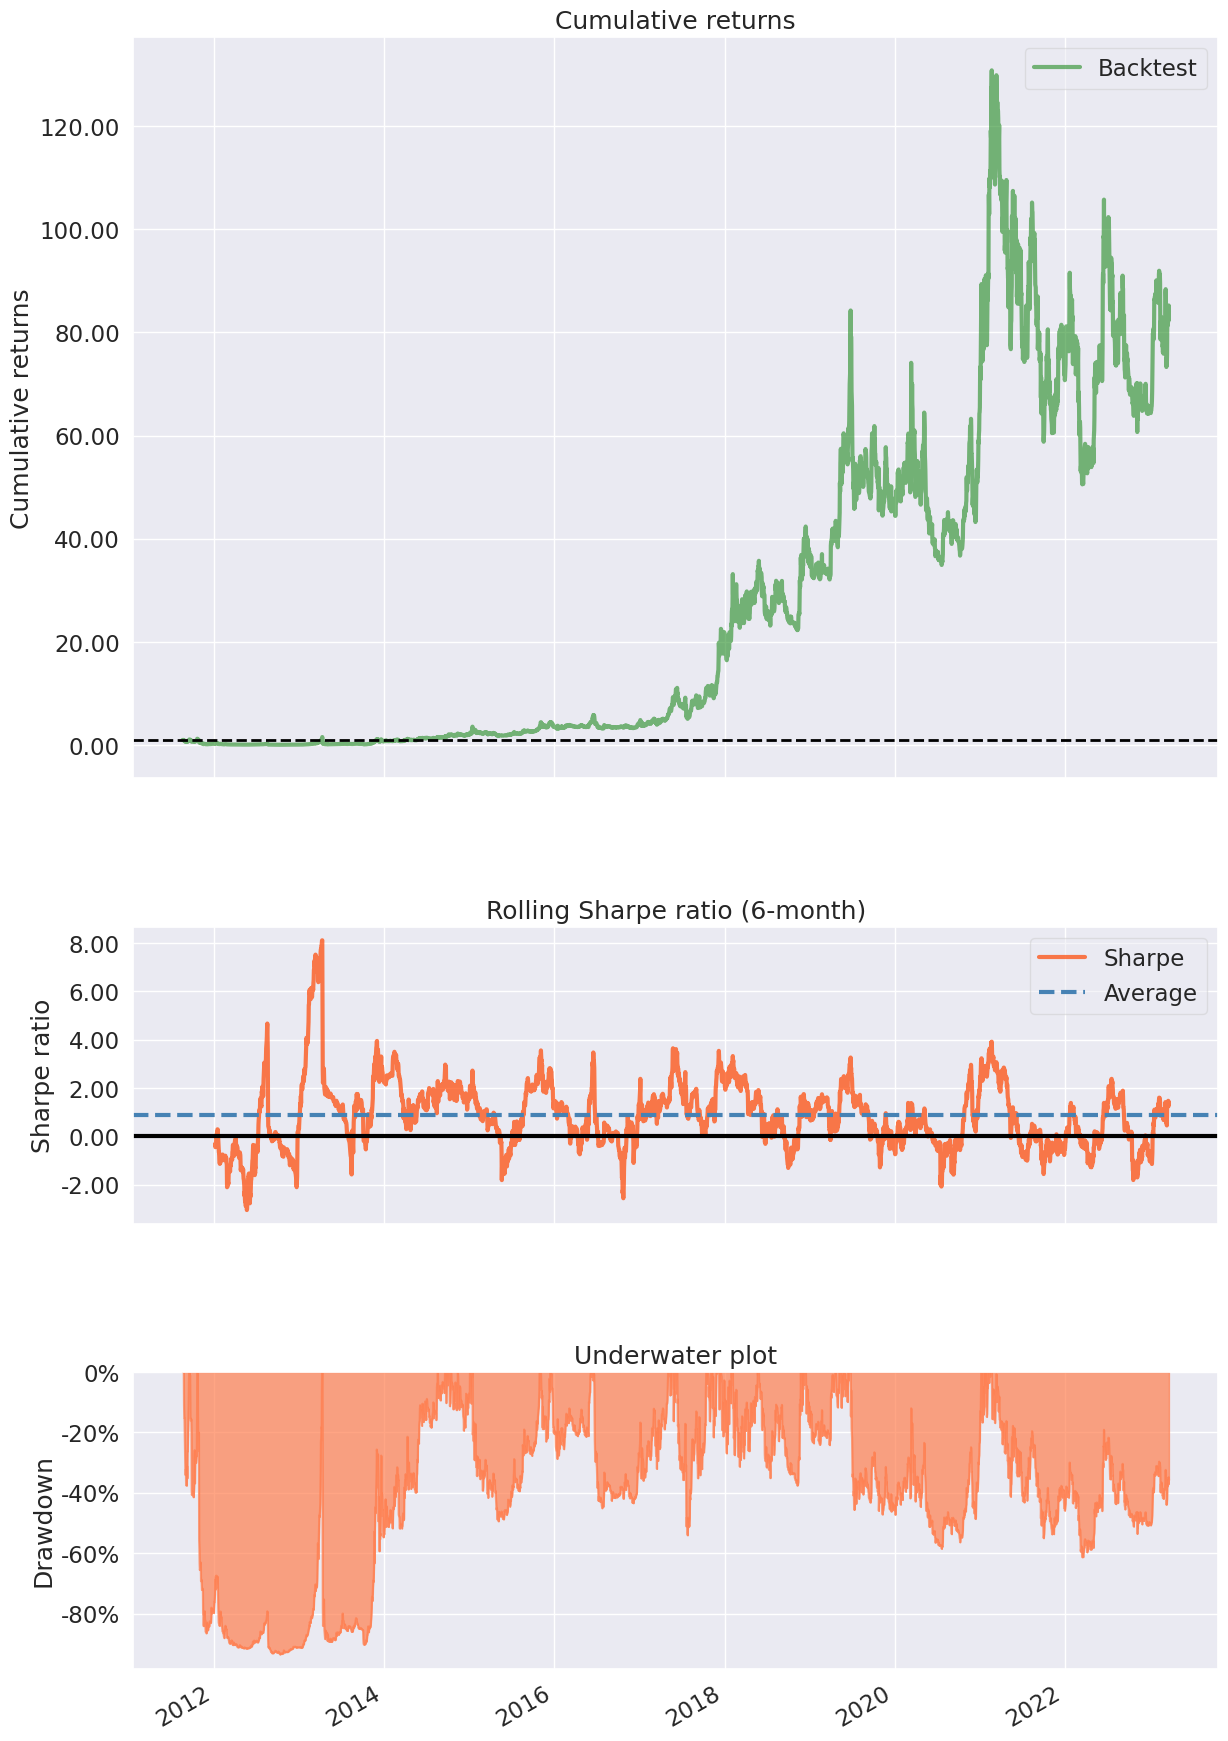

In [55]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())


In [56]:
df['signal'] = df['ehma'] - df['ehma'].shift(1)

In [57]:
df.iloc[-450:-390,:]

,Close,Volume,bnh_returns,ehma,signal,position,strategy_returns
timestamp,,,,,,,
2021-12-30,47150.71,2162.270443,8.372342,48317.841522,-286.931928,-1.0,9.027081
2021-12-31,46214.37,1798.552604,8.352283,47933.358827,-384.482695,-1.0,9.047139
2022-01-01,47777.42,741.520603,8.385546,47686.230626,-247.128202,-1.0,9.013877
2022-01-02,47350.22,702.094755,8.376564,47488.464311,-197.766315,-1.0,9.022858
2022-01-03,46439.89,1140.179088,8.357151,47244.655733,-243.808577,-1.0,9.042271
2022-01-04,45820.00,1832.612837,8.343713,46939.142795,-305.512938,-1.0,9.055709
2022-01-05,43435.80,3397.545778,8.290276,46396.042635,-543.100161,-1.0,9.109146
2022-01-06,43097.60,2450.113094,8.282460,45746.960638,-649.081996,-1.0,9.116962
2022-01-07,41535.66,2984.205861,8.245545,44946.860938,-800.099700,-1.0,9.153877


<AxesSubplot:xlabel='timestamp'>

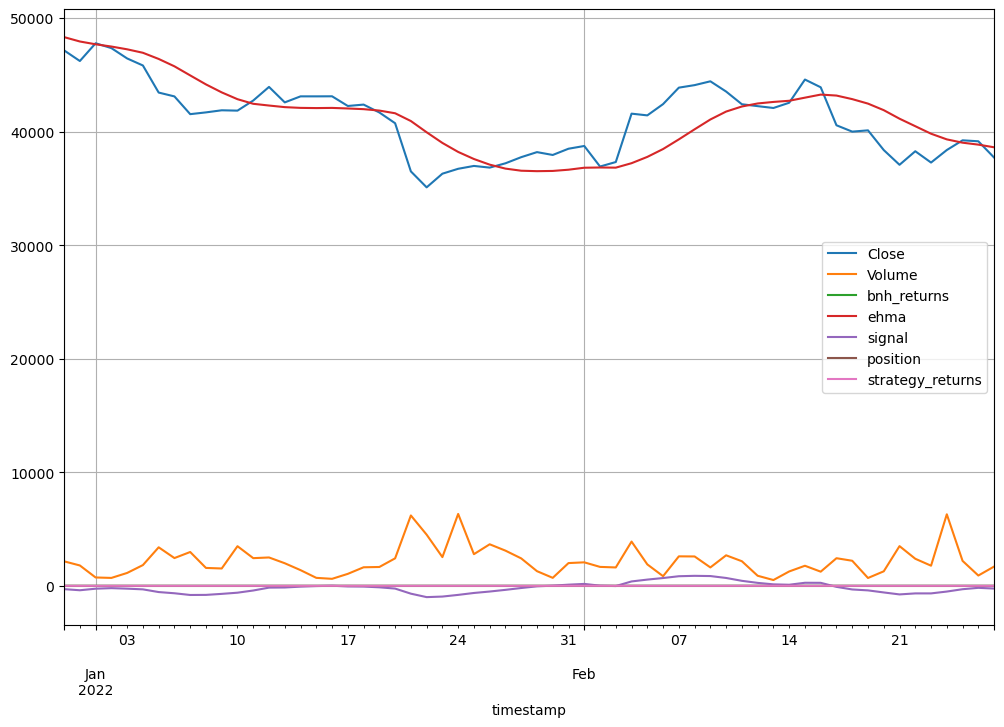

In [58]:
df.iloc[-450:-390,:].plot(grid=True, figsize=(12, 8))

# EHMA with second formula

In [6]:
df = btc().copy()

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
df.shape

(4226, 5)

In [9]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Close']/df['Close'].shift(1))

In [11]:
# Add EHMA indicator
period = 20
sqrt_period = np.sqrt(period)

def John_Ehlers(x, y):
    alpha = 2 / (y + 1)
    sum = np.zeros(len(x))
    sum[0] = alpha * x[0]
    for i in range(1, len(x)):
        sum[i] = alpha * x[i] + (1 - alpha) * sum[i-1]
    return sum

close_ema1 = John_Ehlers(df['Close'], int(period / 2))
close_ema2 = John_Ehlers(df['Close'], period)
ehma = John_Ehlers(2 * close_ema1 - close_ema2, sqrt_period)

df['ehma'] =ehma

df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')

#signal
df['signal'] = np.where((df['ehma'] > df['ehma'].shift(1)),1,0)
df['signal'] = np.where( (df['ehma'] < df['ehma'].shift(1)),-1,df['signal'])

# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

In [64]:
#signal
df['signal'] = np.where((df['ehma'] > df['ehma'].shift(1)),1,0)
df['signal'] = np.where( (df['ehma'] < df['ehma'].shift(1)),-1,df['signal'])

# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)


# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

Buy and hold returns: 7.815569822279086
Strategy returns: 9.396949224522613


<AxesSubplot:xlabel='timestamp'>

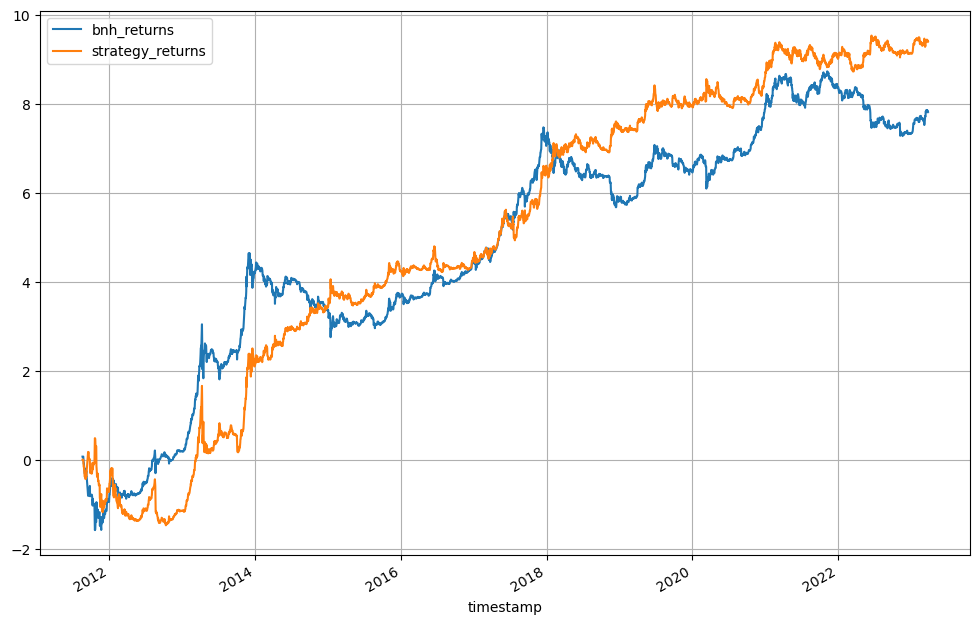

In [13]:
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

Start date,2011-08-18
End date,2023-03-28
Total months,201
,Backtest
Annual return,30.0%
Cumulative returns,8014.2%
Annual volatility,75.3%
Sharpe ratio,0.74
Calmar ratio,0.32
Stability,0.92
Max drawdown,-93.5%


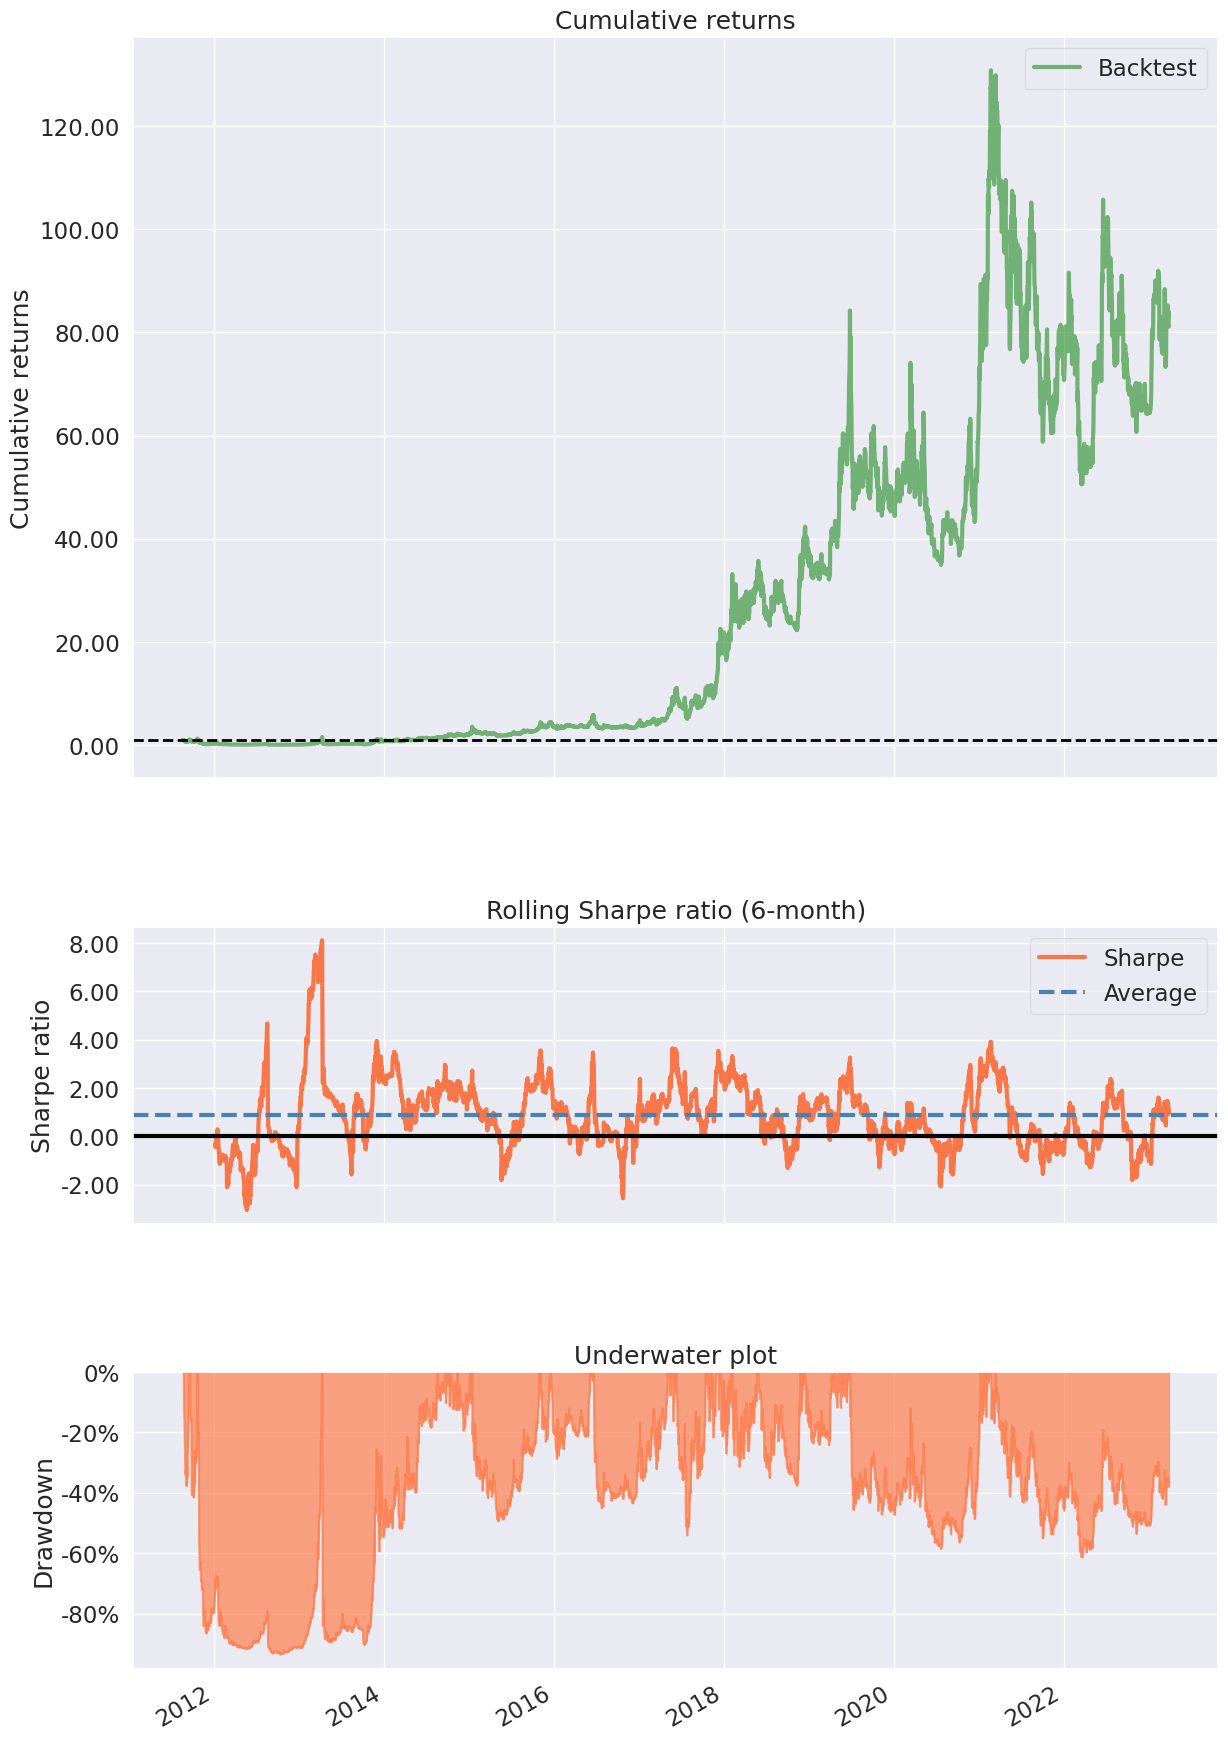

In [14]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())


# Backtesting only last 3years

In [148]:
# EHMA with second formula

df = btc().copy()

df.drop_duplicates(inplace = True)


In [149]:
period = 16

In [150]:
# Add EHMA
sqrt_period = np.sqrt(period)

def John_Ehlers(x, y):
    alpha = 2 / (y + 1)
    sum = np.zeros(len(x))
    sum[0] = alpha * x[0]
    for i in range(1, len(x)):
        sum[i] = alpha * x[i] + (1 - alpha) * sum[i-1]
    return sum

close_ema1 = John_Ehlers(df['Close'], int(period / 2))
close_ema2 = John_Ehlers(df['Close'], period)
ehma = John_Ehlers(2 * close_ema1 - close_ema2, sqrt_period)

df['ehma'] =ehma
df['ehma_1'] = df['ehma'].shift(1)


In [151]:
df = df.loc['2020-01-16':,:]

Buy and hold returns: 1.1309774147294045
Strategy returns: 0.43651565468296816


Start date,2020-01-16
End date,2023-03-28
Total months,55
,Backtest
Annual return,-9.2%
Cumulative returns,-36.2%
Annual volatility,62.3%
Sharpe ratio,0.14
Calmar ratio,-0.12
Stability,0.30
Max drawdown,-75.8%


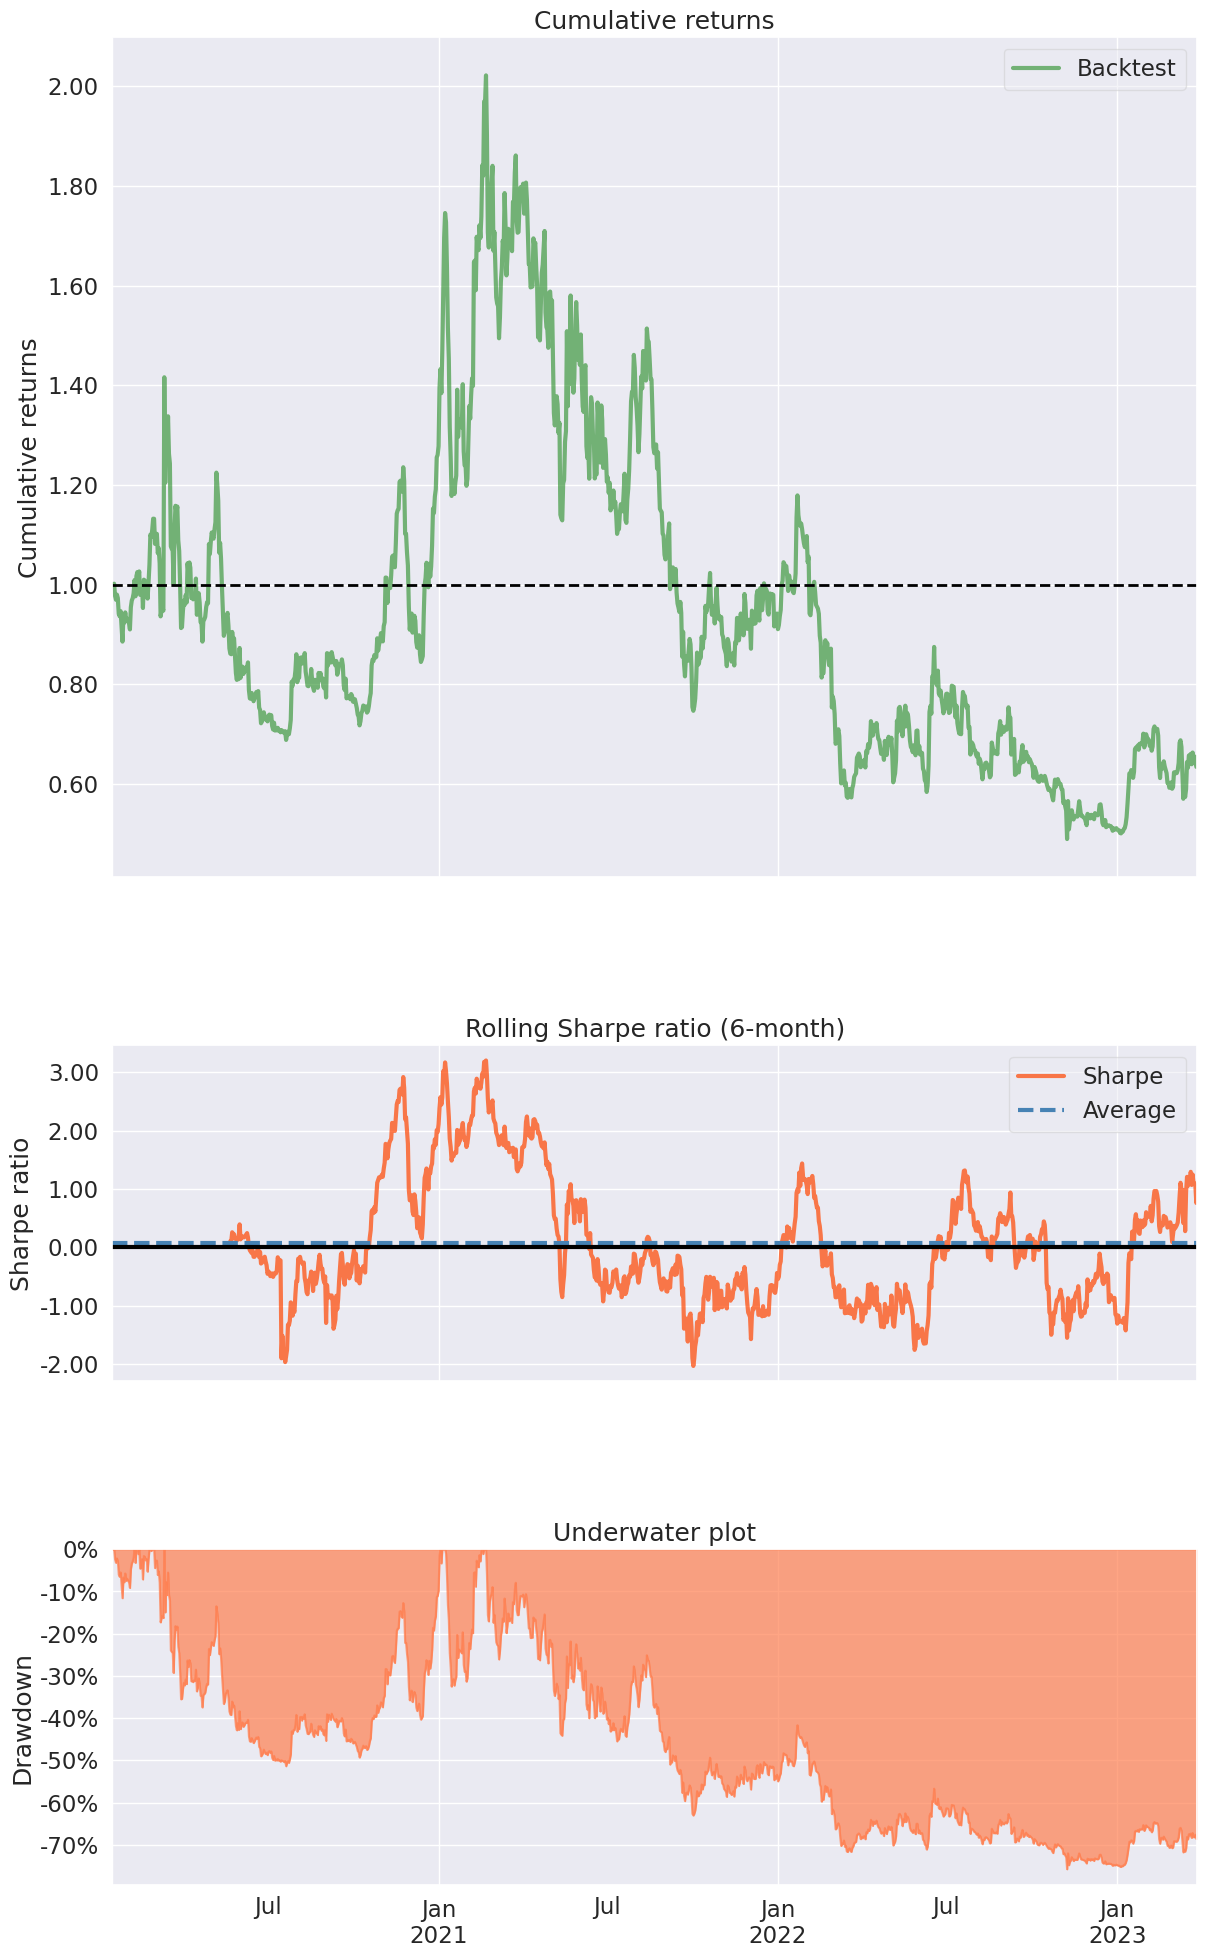

In [152]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Close']/df['Close'].shift(1))


df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')

#signal
df['signal'] = np.where((df['ehma'] > df['ehma_1']),1,0)
df['signal'] = np.where( (df['ehma'] < df['ehma_1']),-1,df['signal'])

# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
#df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

pf.create_simple_tear_sheet(df['strategy_returns'].diff())

In [153]:
df = df.loc['2023-01-01':,:]

Buy and hold returns: 0.48516052522335495
Strategy returns: 0.2642466147921103


Start date,2023-01-01
End date,2023-03-28
Total months,4
,Backtest
Annual return,94.6%
Cumulative returns,25.8%
Annual volatility,47.4%
Sharpe ratio,1.67
Calmar ratio,4.66
Stability,0.09
Max drawdown,-20.3%


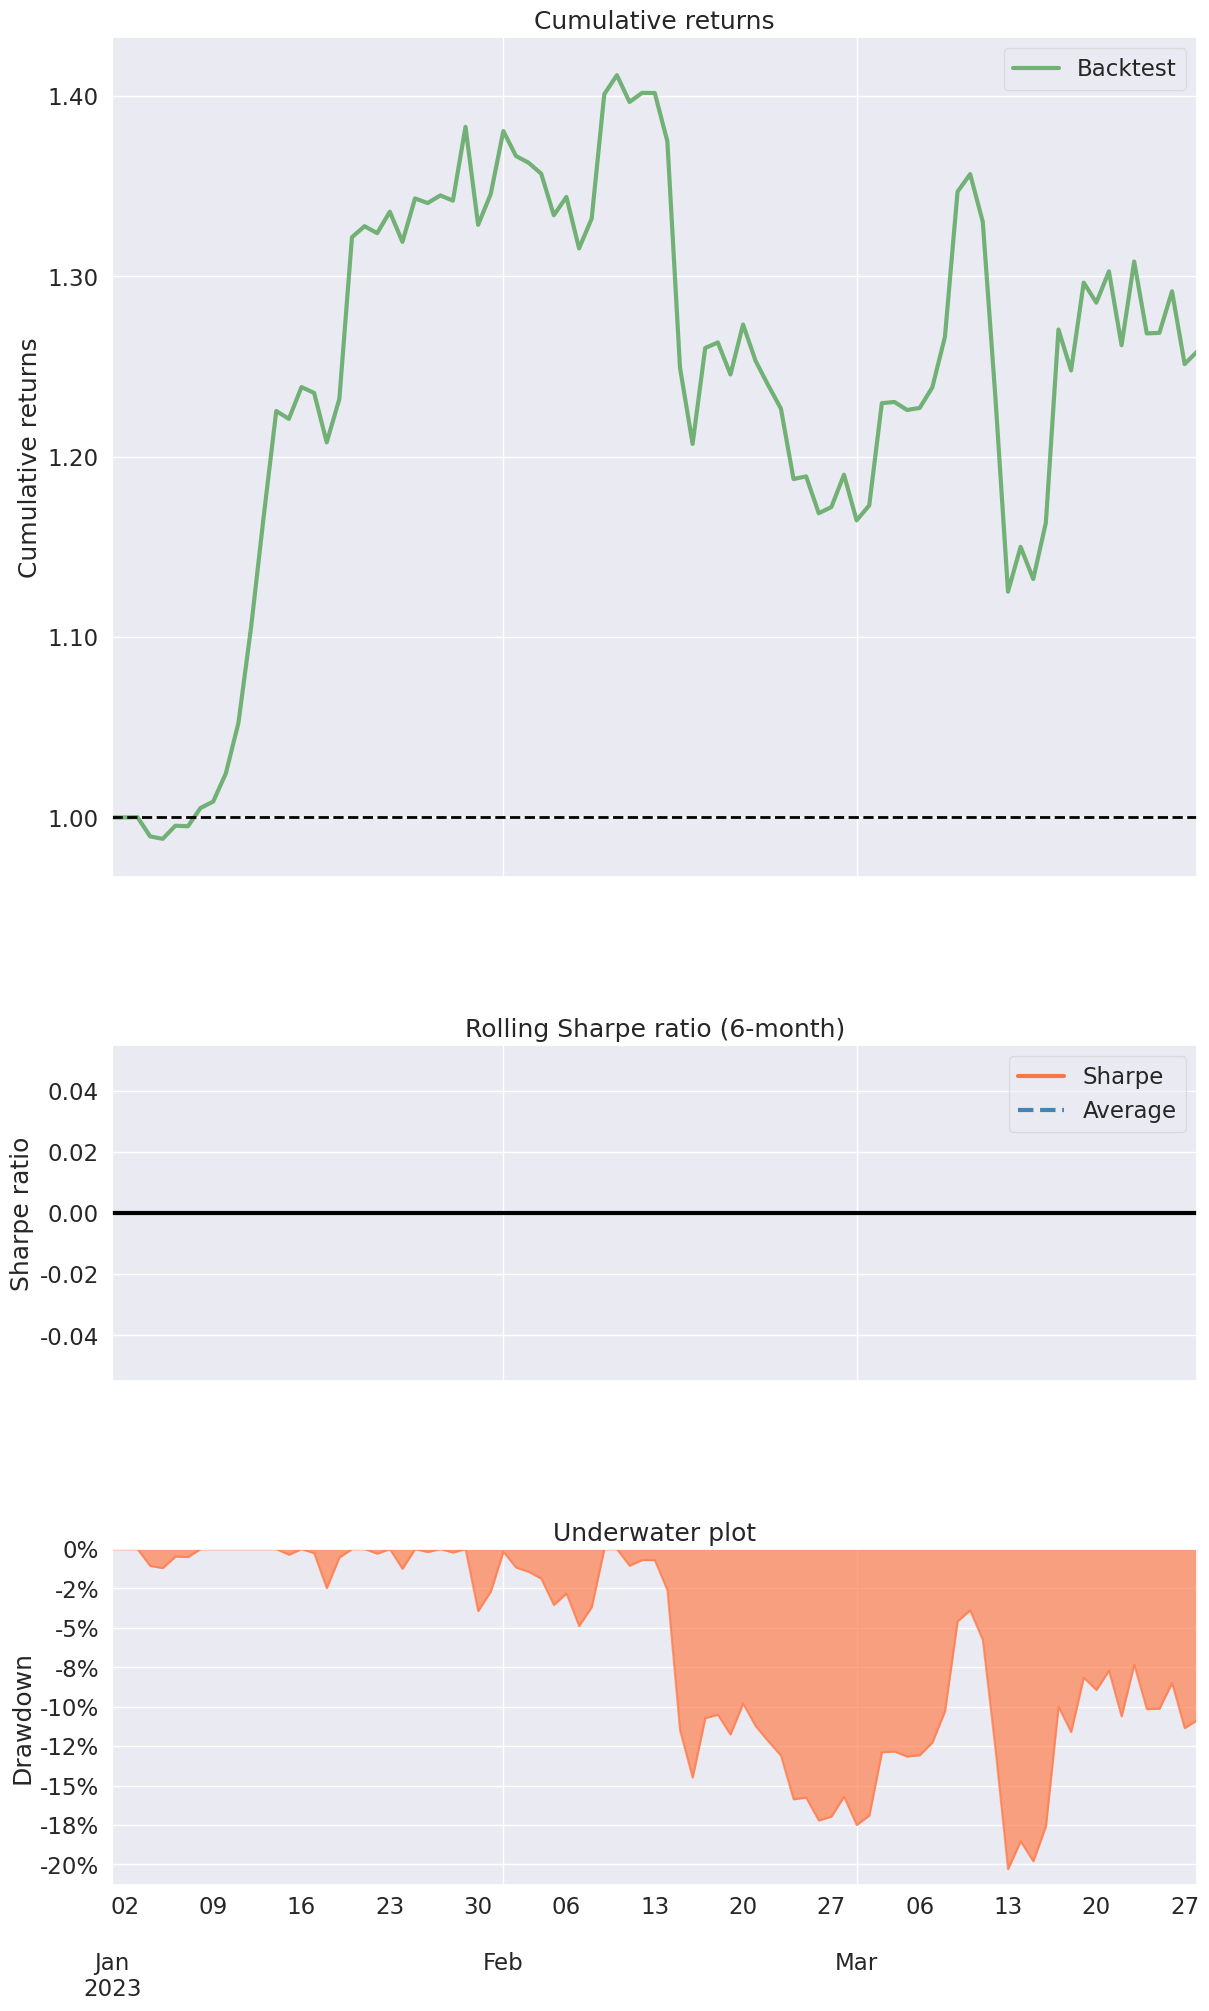

In [154]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Close']/df['Close'].shift(1))


df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')

#signal
df['signal'] = np.where((df['ehma'] > df['ehma_1']),1,0)
df['signal'] = np.where( (df['ehma'] < df['ehma_1']),-1,df['signal'])

# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
#df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

pf.create_simple_tear_sheet(df['strategy_returns'].diff())

In [55]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Close']/df['Close'].shift(1))

period = 4
sqrt_period = np.sqrt(period)

def John_Ehlers(x, y):
    alpha = 2 / (y + 1)
    sum = np.zeros(len(x))
    sum[0] = alpha * x[0]
    for i in range(1, len(x)):
        sum[i] = alpha * x[i] + (1 - alpha) * sum[i-1]
    return sum

close_ema1 = John_Ehlers(df['Close'], int(period / 2))
close_ema2 = John_Ehlers(df['Close'], period)
ehma = John_Ehlers(2 * close_ema1 - close_ema2, sqrt_period)

df['ehma'] =ehma
df['ehma_1'] = df['ehma'].shift(1)

df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')

#signal
df['signal'] = np.where((df['ehma'] > df['ehma_1']),1,0)
df['signal'] = np.where( (df['ehma'] < df['ehma_1']),-1,df['signal'])

# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)




In [56]:
df

,Close,Volume,bnh_returns,ehma,ehma_1,signal,position
timestamp,,,,,,,
2011-08-18,10.90,0.489908,NaN,6.782222,NaN,0,0
2011-08-19,11.69,1.926578,0.069971,11.020148,6.782222,1,1
2011-08-20,11.70,0.085470,0.000855,12.576830,11.020148,1,1
2011-08-22,11.70,0.028632,0.000000,12.830279,12.576830,1,1
2011-08-23,11.70,0.000000,0.000000,12.638206,12.830279,-1,-1
...,...,...,...,...,...,...,...
2023-03-22,27320.00,5024.210406,-0.031419,27866.536902,28367.944115,-1,-1
2023-03-23,28343.00,3199.654512,0.036761,28170.741031,27866.536902,1,1
2023-03-24,27493.00,2789.449515,-0.030449,27841.104942,28170.741031,-1,-1


In [57]:
# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])




In [58]:
df

,Close,Volume,bnh_returns,ehma,ehma_1,signal,position,strategy_returns
timestamp,,,,,,,,
2011-08-18,10.90,0.489908,NaN,6.782222,NaN,0,0,NaN
2011-08-19,11.69,1.926578,0.069971,11.020148,6.782222,1,1,0.069971
2011-08-20,11.70,0.085470,0.000855,12.576830,11.020148,1,1,0.000855
2011-08-22,11.70,0.028632,0.000000,12.830279,12.576830,1,1,0.000000
2011-08-23,11.70,0.000000,0.000000,12.638206,12.830279,-1,-1,-0.000000
...,...,...,...,...,...,...,...,...
2023-03-22,27320.00,5024.210406,-0.031419,27866.536902,28367.944115,-1,-1,0.031419
2023-03-23,28343.00,3199.654512,0.036761,28170.741031,27866.536902,1,1,0.036761
2023-03-24,27493.00,2789.449515,-0.030449,27841.104942,28170.741031,-1,-1,0.030449


Buy and hold returns: 7.846112668012872
Strategy returns: 101.13143144835169


<AxesSubplot:xlabel='timestamp'>

Start date,2011-08-18
End date,2023-03-26
Total months,201
,Backtest
Annual return,31996.5%
Cumulative returns,1.0304087687456944e+44%
Annual volatility,65.1%
Sharpe ratio,9.27
Calmar ratio,1159.62
Stability,1.00
Max drawdown,-27.6%


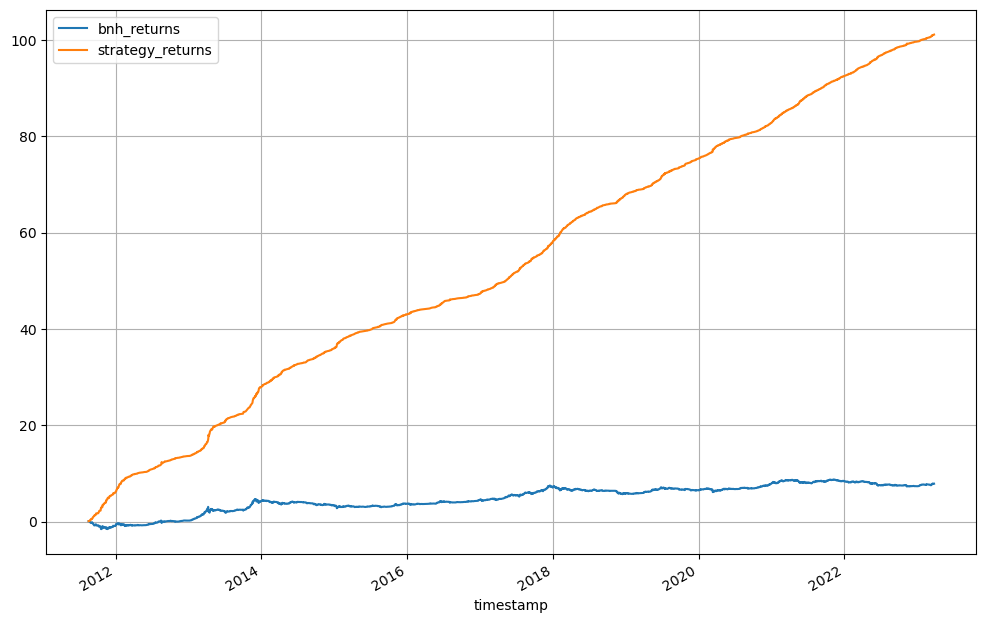

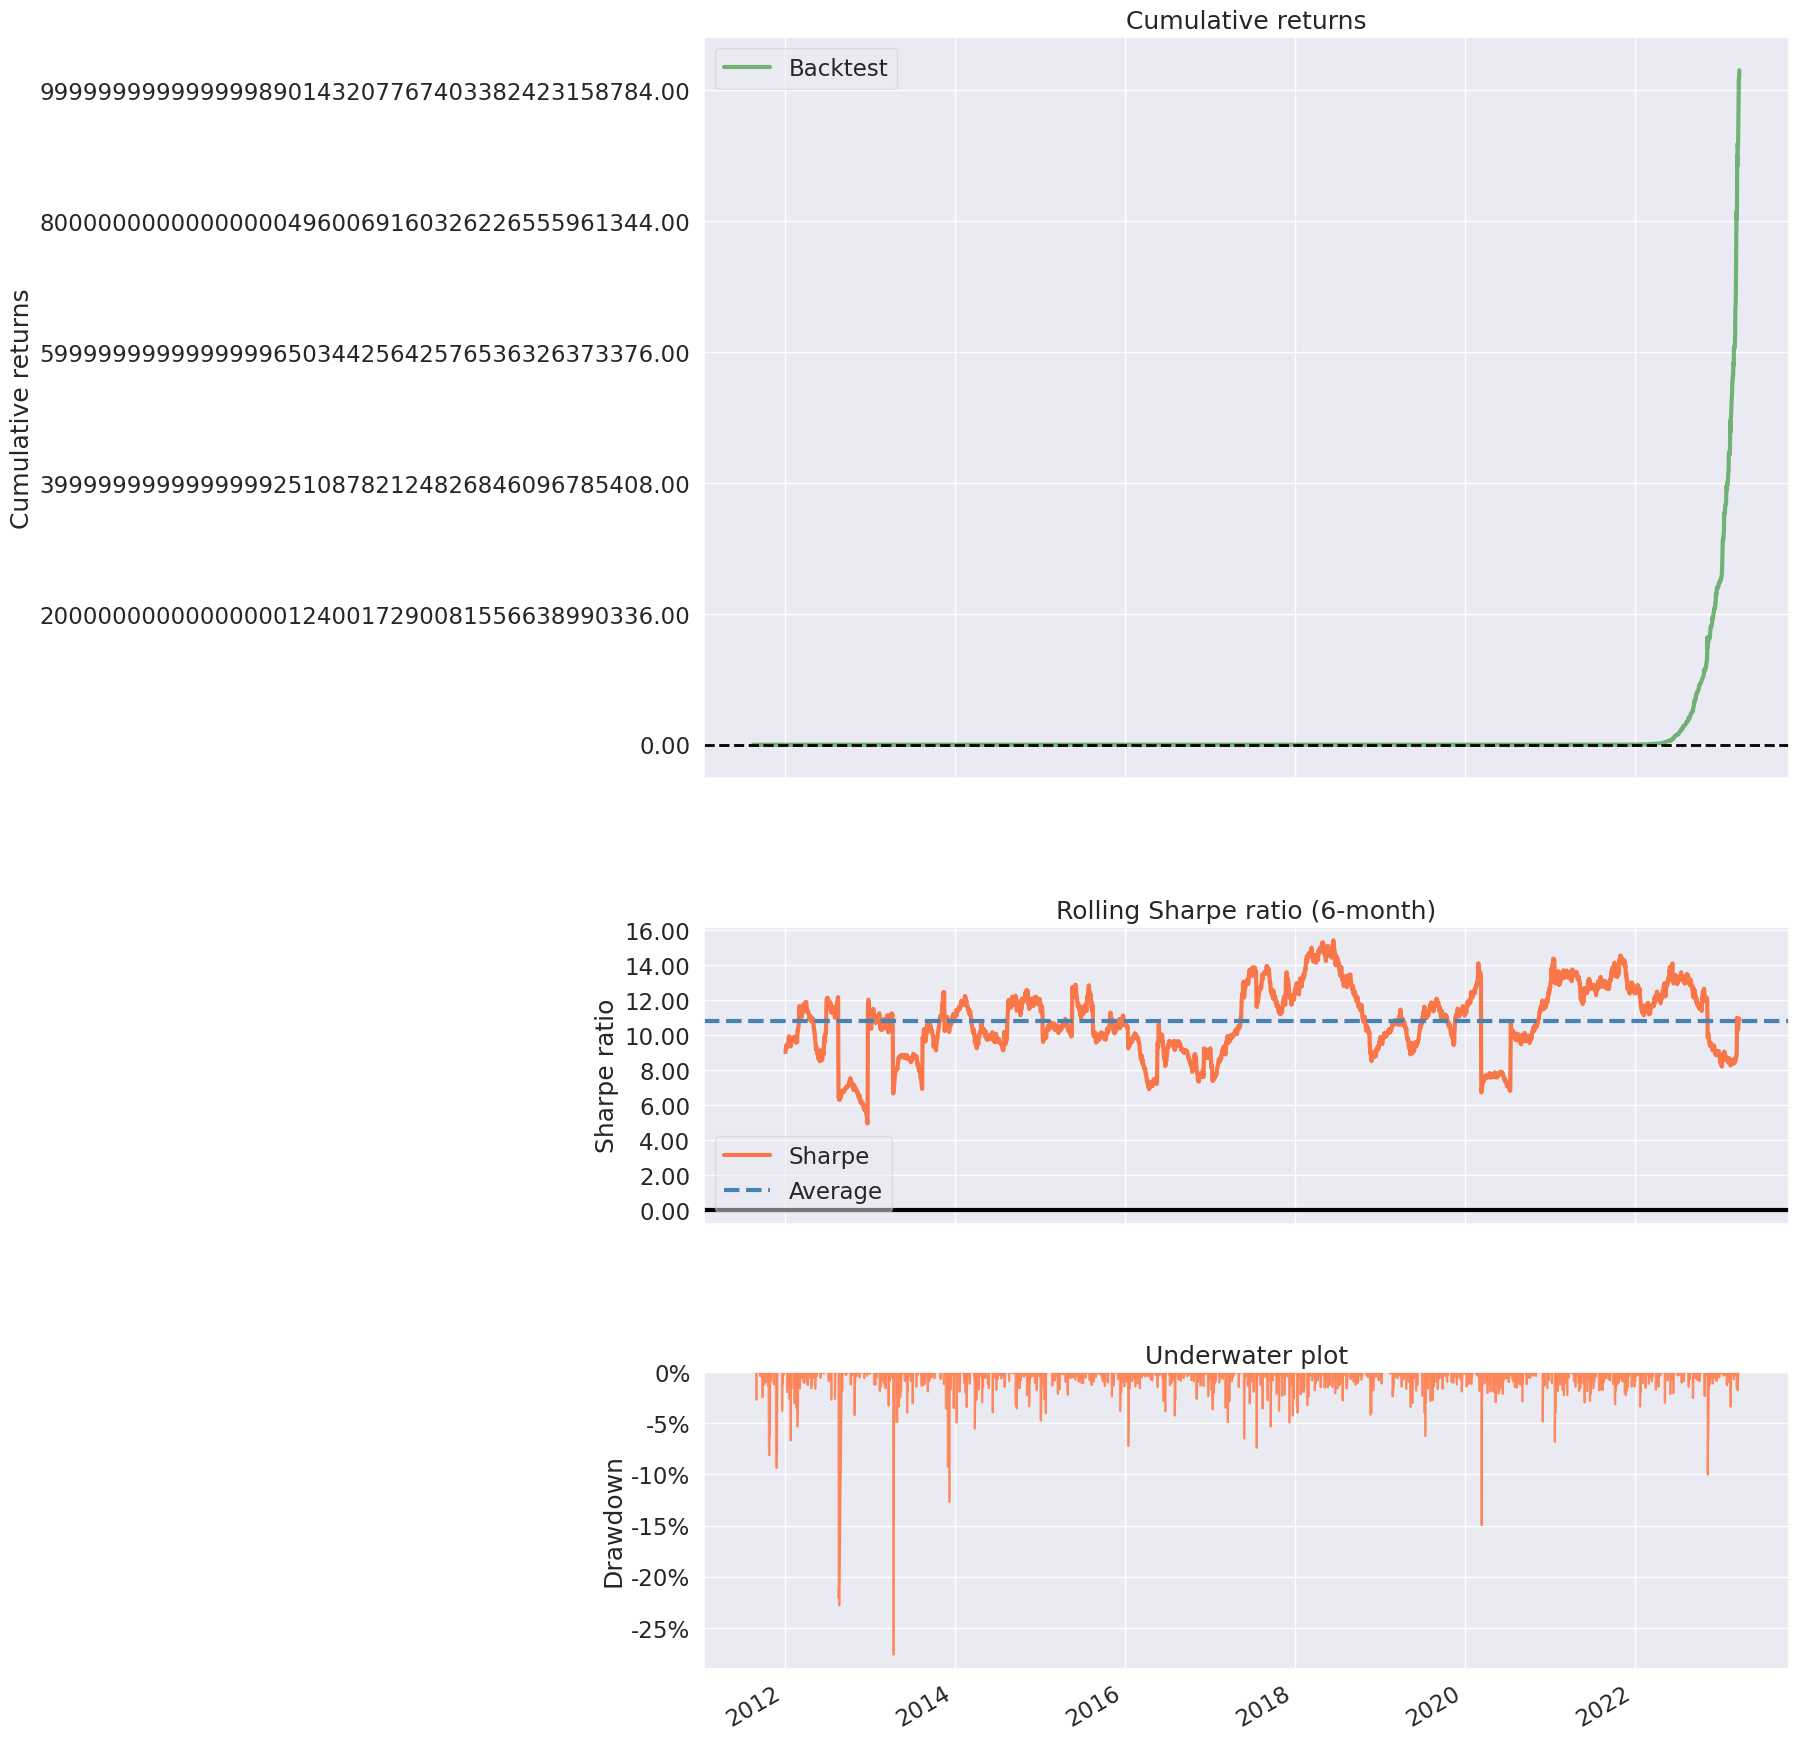

In [59]:
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

pf.create_simple_tear_sheet(df['strategy_returns'].diff())

In [11]:
df

,Close,High,Low,Open,Volume
timestamp,,,,,
2011-08-18,10.90,10.90,10.90,10.90,0.489908
2011-08-19,11.69,11.85,11.15,11.85,1.926578
2011-08-20,11.70,11.70,11.70,11.70,0.085470
2011-08-22,11.70,11.70,11.70,11.70,0.028632
2011-08-23,11.70,11.70,11.70,11.70,0.000000
...,...,...,...,...,...
2023-03-23,28343.00,28818.00,27187.00,27320.00,3199.654512
2023-03-24,27493.00,29380.00,27043.00,28352.00,2789.449515
2023-03-25,27499.00,27810.00,27210.00,27497.00,963.838407
